In [70]:
import matplotlib.pyplot as plt
from pandas import read_csv
%matplotlib inline
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [72]:
#data = read_csv("data.csv",parse_dates=True,index_col=0) #la premiere colonne est mise en index et comme elle est l'index elle est plus dans le fichier.
data = pd.read_csv('data.csv',sep=',', usecols=['Date & Time','P_global| [kW]','P_heat| [kW]'], index_col=0, parse_dates=True)
data.keys()


Index(['P_global| [kW]', 'P_heat| [kW]'], dtype='object')

# sampling data:

In [73]:
data =data.resample('15Min').mean() #chaque ligne dans ce cas correspond a 15 mins de données.
data=data.dropna()
data

,P_global| [kW],P_heat| [kW]
Date & Time,,
2019-08-08 16:30:00,2.537,0.001
2019-08-08 17:30:00,2.283,0.001
2019-08-08 18:30:00,1.738,0.001
2019-08-08 19:30:00,2.043,0.000
2019-08-08 20:30:00,4.455,0.003
...,...,...
2021-02-10 05:30:00,2.320,0.011
2021-02-10 06:30:00,2.315,0.013
2021-02-10 07:30:00,3.033,0.013


# Préparation des données:

In [74]:
data['day of the week'] =  data.index.dayofweek
data['day of the year'] =  data.index.dayofyear
data['hour of the day'] =  data.index.hour
data['number of the week'] =  data.index.week
data['minute of the hour'] =  data.index.minute

C:\Users\User\anaconda3\envs\TP\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  after removing the cwd from sys.path.


# RNN

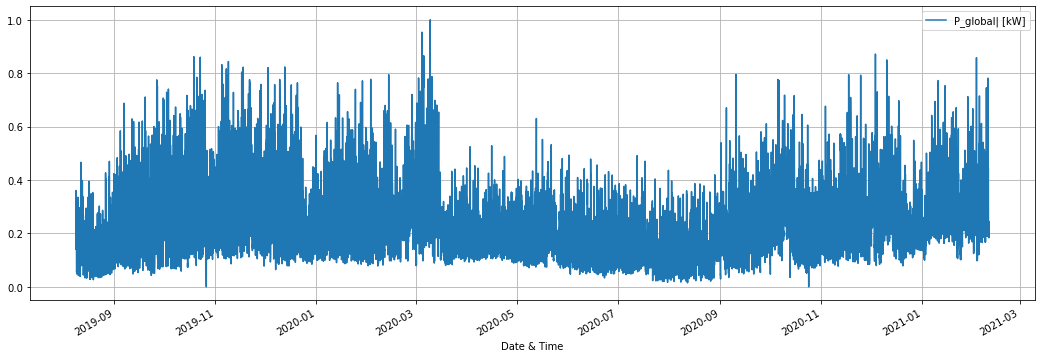

In [75]:
features = ['day of the week', 'hour of the day', 'minute of the hour', 'number of the week']
labels   = ['P_global| [kW]']#, 'P_heat| [kW]'
inputs   = features + labels
data = data[inputs]

shift_days = 10 # cet algo predicition, il n'utilise pas classification
shift_steps = shift_days*4 #(4*15*10 donne 10 heures)
data_targets = np.roll(data[labels],-shift_steps)

scaler = MinMaxScaler() # donne des valeurs entre 0 et 1
data_scaled = pd.DataFrame(scaler.fit_transform(data.values), columns=data.columns, index=data.index)

fig = plt.figure(figsize=(18, 6))
ax = fig.add_subplot(111)
data_scaled[labels].plot(ax=ax)
plt.grid(True)
plt.show()

## Commentaire sur le graphe:
O peut clairement voir une dimunition de la consommation d'énergie à la Maisel durant le confinement qui a eu lieu à partir du mois 3 (Mars) jusqu'au mois 9 ( Septembre)

## Séparation des données:


In [76]:
def split_data(data, test_size=0.25): #et donc on a train_size=0.75
    """
    splits data to training and testing parts
    """
    ntest =  int(round(len(data)*(1-test_size))) #on a arrondi
    
    data_train, data_test = data.iloc[:ntest], data.iloc[ntest:]
    
    return data_train, data_test

In [101]:
data_train, data_test = split_data(data_scaled, test_size=0.25)
x_train_scaled = np.asarray(data_train[features])
x_test_scaled = np.asarray(data_test[features])  
y_test_scaled = np.asarray(data_test[labels])   
y_train_scaled = np.asarray(data_train[labels])

num_test = len(data_test)
num_train = len(data_train)
num_total = len(data)

print("Longueur totales des data pour le testing :",num_test)
print("Longueur totales des data pour le training :",num_train)
print("Longueur totales des data :", num_total)

Longueur totales des data pour le testing : 3310
Longueur totales des data pour le training : 9931
Longueur totales des data : 13241


In [102]:
num_features = len(features)
num_labels = len(labels)
num_inputs = num_features + num_labels

print('Longueur totale des données :', num_features)
print('Longueur totale des données de Labels (Test):', num_labels) 
print(' Longueur totale des données d\'apprentissage (Train):', num_inputs)

Longueur totale des données : 4
Longueur totale des données de Labels (Test): 1
 Longueur totale des données d'apprentissage (Train): 5


In [103]:
def batch_generator(batch_size, sequence_length, num_features, num_labels, num_test, x, y):
    """
    Generator function for creating random batches of training-data.
    """
 # batch = unitee de donnee que je transmet en donne (volume de la cuillère)
    while True:
        #allocate a new array for the batch of the input-signal
        x_shape = (batch_size, sequence_length, num_features)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)
    
        #allocate a new array for the batch of the output-signal
        y_shape = (batch_size, sequence_length, num_labels)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)
        
        #fill the bach with random sequence of data
        for i in range (batch_size) :
                #get a random start index
                #this points somewhere into the trainning data
            if num_test < sequence_length :
                print("there will be a problem test too short", num_test)
            idx = np.random.randint(num_test - sequence_length)
            
            #copy the sequence of data starting at this index
            x_batch[i] = x[idx:idx+sequence_length]
            y_batch[i] = y[idx:idx+sequence_length]
        
        yield (x_batch, y_batch) # yield n'est pas un return , on l'utilise pour ne pas initialise le nbre aleatoire


In [104]:
batch_size = 50     #metaparameters        
sequence_length = int(60/15*24) # donc on a 4 (60/15 car on a échantilloné en des sequences de 15 mins) sequences par heures et donc dans chaque jour on aura 4 * 24  
generator = batch_generator(batch_size, sequence_length, num_features, num_labels, num_train, x_train_scaled, y_train_scaled)
testgenerator = batch_generator(batch_size, sequence_length, num_features, num_labels, num_test, x_test_scaled, y_test_scaled)
x_batch, y_batch =  next(generator)
print(f'X Batch Shape :  {x_batch.shape}')
print(f'Y Batch Shape :  {x_batch.shape}')
seq = x_batch[0, :, :]


X Batch Shape :  (50, 96, 4)
Y Batch Shape :  (50, 96, 4)


# Réseau de Neurones:

In [105]:
from tensorflow.keras.utils import Progbar # reseau rnn (notion de temps) // pr classification on utilise cnn

num_neurons = 200 # was 10
learning_rate = 0.001
num_layers = 6 #chaqur cellule a 4(lstm) gates et chaqu'une de ces options est replique 100 fois
num_iter = 200
keep_prob = 0.2

next(testgenerator) # on itère sur les différents text generator
graph = tf.Graph() 
with graph.as_default():
    x = tf.placeholder(tf.float32, [None, sequence_length, num_features], name="x") 
    y = tf.placeholder(tf.float32, [None, sequence_length, num_labels], name="y") 
    def get_a_cell(lstm_size, keep_prob):     
        lstm= tf.nn.rnn_cell.LSTMCell(lstm_size) 
        drop = tf.nn.rnn_cell.DropoutWrapper(lstm, output_keep_prob=keep_prob)
        return drop
    
    with tf.name_scope('lstm'): 
        cell= tf.nn.rnn_cell.MultiRNNCell([get_a_cell(num_neurons, 1-keep_prob) for _ in range(num_layers)])
        
    outputs, current_state= tf.nn.dynamic_rnn(cell, x, dtype=tf.float32)


    stacked_rnn_output = tf.reshape(outputs, [-1, num_neurons])           #change the form into a tensor
    stacked_outputs = tf.layers.dense(stacked_rnn_output, num_labels)        #specify the type of layer (dense)
    outputs = tf.reshape(stacked_outputs, [-1, sequence_length, num_labels])          #shape of results

    loss =     tf.losses.mean_squared_error(y, outputs) # calcule l'erreur
    optimizer =      tf.train.AdamOptimizer(learning_rate = learning_rate) #corrige tous les poids avec cet erreur
     
    train = optimizer.minimize(loss) #back propagation 
    init = tf.global_variables_initializer()
    with tf.Session(graph=graph) as sess:
        sess.run(init)
        histogram_summary = tf.summary.scalar('MSE', loss)
        merged = tf.summary.merge_all()
        writer = tf.summary.FileWriter('./graphs', sess.graph)
        progbar = Progbar(num_iter)
                
        for iter in range(num_iter): #boucle d'entrainement
            x_batch, y_batch =     next(generator)
            _current_state, l =     sess.run([current_state, train], feed_dict={x: x_batch, y: y_batch})
            histogram_summary = tf.summary.histogram('My_histogram_summary', loss)
            res_sum = sess.run(merged, feed_dict={x: x_batch, y: y_batch}) 
            mse = loss.eval(feed_dict={x: x_batch, y: y_batch})
            writer.add_summary(res_sum, iter)
            progbar.update(iter, values=[('MSE', mse)])
                            
        x_btest, ybtest = next(testgenerator) #debut du test
        y_pred = sess.run(outputs, feed_dict={x: x_batch, y: y_batch})
        
        ind = (len(x_test_scaled)//(sequence_length))*sequence_length
        x_test_tensor = x_test_scaled[0:ind].reshape([-1, sequence_length, num_features])
        y_model = sess.run(outputs, feed_dict={x: x_test_tensor})
        

199/200 [============================>.] - ETA: 1s - MSE: 0.0159

# Affichage des données:

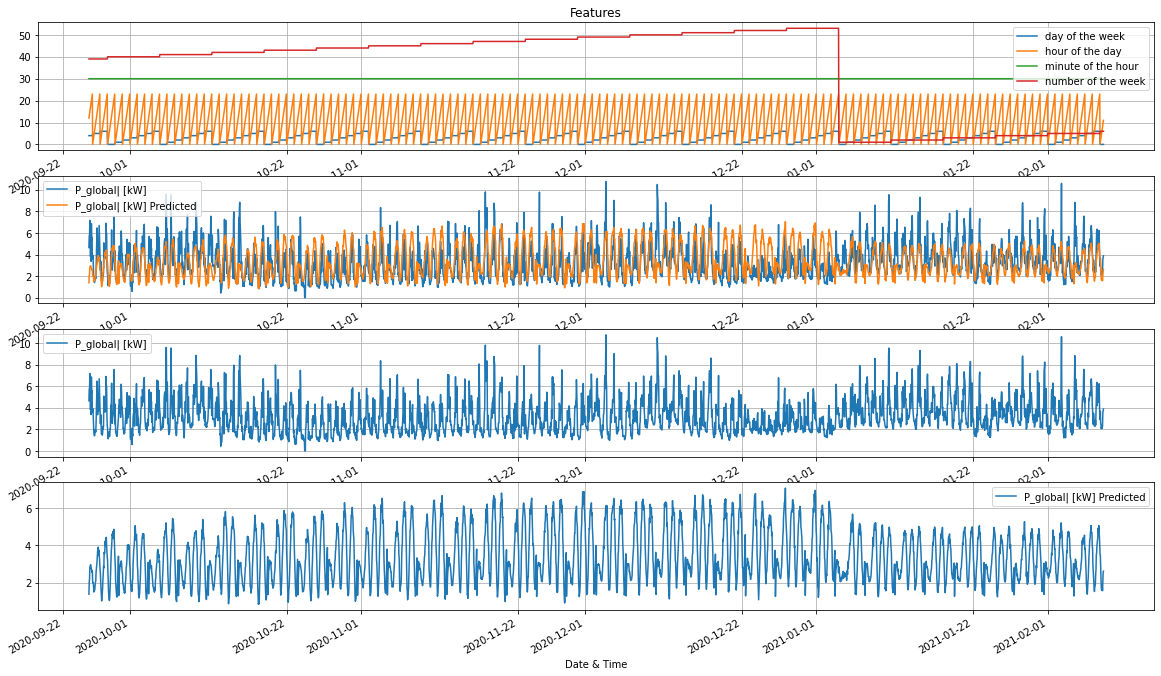

In [107]:
y_test = y_model.reshape(-1, num_labels)

scaler.fit(data[labels])
x = scaler.inverse_transform(y_test)
signal_pred = np.roll(x,shift_steps)
DATA = pd.DataFrame(scaler.inverse_transform(y_test), index=data_test.iloc[0:ind].index, columns=labels)

fig = plt.figure(figsize=(20, 12))

ax = fig.add_subplot(411)
data[features].loc[DATA.index].plot(ax=ax)
plt.grid()
plt.title('Features')


ax = fig.add_subplot(412)
data[labels[0]].loc[DATA.index].plot(ax=ax)
DATA[labels[0]].plot(ax=ax, label=labels[0]+' Predicted')
plt.legend()
plt.grid()

ax = fig.add_subplot(413)
data[labels[0]].loc[DATA.index].plot(ax=ax)
plt.legend()
plt.grid()

ax = fig.add_subplot(414)
DATA[labels[0]].plot(ax=ax, label=labels[0]+' Predicted')
plt.legend()
plt.grid()



#ax = fig.add_subplot(313)
#df[labels[1]].loc[DF.index].plot(ax=ax)
#DF[labels[1]].plot(ax=ax, label=labels[1]+' Predicted')
#plt.legend()
#plt.grid()


# Déduction:
On remarque que la prédiction n'est pas assez précise a cause du manque du scale sur les données qu'on entraine, tandis que quand on ajoute le scale on aura une meilleure précision.

# Calcul d'erreurs:

In [108]:
from math import sqrt
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_pred.reshape(-1,1), ybtest.reshape(-1,1))
print('MSE : %.3f' % mse)
rmse = sqrt(mean_squared_error(y_pred.reshape(-1,1), ybtest.reshape(-1,1)))
print('RMSE : %.3f' % rmse)

MSE : 0.028
RMSE : 0.167


<AxesSubplot:xlabel='Date & Time'>

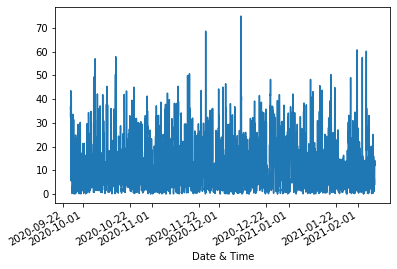

In [110]:
l=y_pred[:,1]
L=y_pred[1,:]
y_comp = np.zeros((50,96))
y_comp=y_pred-ybtest
((abs(data[labels[0]].loc[DATA.index]-DATA[labels[0]]))*10).plot()

# Classification et erreurs:

In [115]:
Erreur = 15
d=pd.DataFrame(index=data_test.iloc[0:ind].index, columns=['Données test','Données pred'])
d['Données test']=data[labels[0]].loc[DATA.index]
d['Données pred']=DATA[labels[0]]
d['Anomalie']=abs(data[labels[0]].loc[DATA.index]-DATA[labels[0]])*10>Erreur # Toute les erreurs inferieures à 15% sont "false", les autres sont "true" => classification
d.Anomalie.sum()*100/len(d.Anomalie)
print('Les Anomalies de plus de %i%% representent %5.2f%% des valeurs'% (Erreur,d.Anomalie.sum()*100/len(d.Anomalie)))

Les Anomalies de plus de 15% representent 30.76% des valeurs


In [119]:
print('En utilisant les données prédites : ')
data['Weekend']=data['day of the week']>5
d['Weekend']=data.loc[DATA.index].Weekend
normal=d[d.Weekend==False]['Données pred'].mean()
wkd=d[d.Weekend]['Données pred'].mean()
print('Puissance moyenne pdt le weekend : %1.3f kW' %wkd)
print('Puissance moyenne totale : %1.3f kW'%normal)

data['hiver1']=data['number of the week']<10
data['hiver2']=data['number of the week']>40
data['hiver']=data.hiver1+data.hiver2
d['hiver']=data.loc[DATA.index].hiver
normalh=d[d.hiver==False]['Données pred'].mean()
hiv=d[d.hiver]['Données pred'].mean()
print('Puissance moyenne pdt l hiver : %1.3f kW' %hiv)
print('Puissance moyenne totale : %1.3f kW'%normalh)


import datetime 
print('\nEn utilisant l ensemble des données :')
confinement1 = (data.index.date>datetime.date(2020, 3, 16)) & (data.index.date <= datetime.date(2020, 5, 11))
confinement2 = (data.index.date>datetime.date(2020, 10, 30)) & (data.index.date <= datetime.date(2020, 12, 15))

print('Puissance moyenne pdt le premier confinement : %1.3f kW' %data.loc[confinement1,'P_global| [kW]'].mean())
print('Puissance moyenne pdt le second confinement : %1.3f kW' %data.loc[confinement2,'P_global| [kW]'].mean())
print('Puissance moyenne totale : %1.3f kW'%data['P_global| [kW]'].mean())

print('\n>> 1er confinement : très peu de présence sur le campus, températures douces, peu d\'activités de recherche')
print('>> 2e confinement : labos utilisés, plus d\'étudiants présents, chauffage')

En utilisant les données prédites : 
Puissance moyenne pdt le weekend : 3.298 kW
Puissance moyenne totale : 3.429 kW
Puissance moyenne pdt l hiver : 3.458 kW
Puissance moyenne totale : 2.765 kW

En utilisant l ensemble des données :
Puissance moyenne pdt le premier confinement : 2.346 kW
Puissance moyenne pdt le second confinement : 3.141 kW
Puissance moyenne totale : 2.936 kW

>> 1er confinement : très peu de présence sur le campus, températures douces, peu d'activités de recherche
>> 2e confinement : labos utilisés, plus d'étudiants présents, chauffage


C:\Users\User\anaconda3\envs\TP\lib\site-packages\pandas\core\computation\expressions.py:204: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "
